# TCIPC analysis with different amount of harmonics

## Loading data

In [2]:
import socket

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata
from weis.visualization.utils import load_OMsql_multi, load_OMsql

socket.gethostname()  # Should not be a login node.

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.DeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/pkg_resources/__init__.py:3146
Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packagesDeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/jsonmerge/__init__.py:27
Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.PendingDeprecati

'J1YCSV3'

In [ ]:
# Load the data.
log_fmt = (
    "../../data/design_of_experiments/ps_vs_ipc_all_sweep/log_ps_vs_ipc_all_sweep.sql*"
)
data_dict = load_OMsql_multi(log_fmt)
data_dict.keys()

This process (pid=2201) is multi-threaded, use of fork() may lead to deadlocks in the child.

dict_keys(['aeroelastic.platform_displacement', 'aeroelastic.hub_system_cm', 'aeroelastic.platform_elem_rho', 'aeroelastic.platform_elem_E', 'aeroelastic.platform_elem_G', 'aeroelastic.platform_total_center_of_mass', 'aeroelastic.platform_mass', 'aeroelastic.platform_I_total', 'aeroelastic.beta_wave', 'aeroelastic.gamma_f', 'aeroelastic.gamma_m', 'aeroelastic.E', 'aeroelastic.twr2shaft', 'aeroelastic.Xt', 'aeroelastic.Xc', 'aeroelastic.m', 'aeroelastic.definition_layer', 'aeroelastic.sc_ss_mats', 'aeroelastic.sc_ps_mats', 'aeroelastic.te_ss_mats', 'aeroelastic.te_ps_mats', 'aeroelastic.monopile_wohlerexp', 'aeroelastic.monopile_wohlerA', 'aeroelastic.monopile_ultstress', 'aeroelastic.pitch_axis', 'aeroelastic.monopile_axial_load2stress', 'aeroelastic.monopile_shear_load2stress', 'aeroelastic.transition_node', 'aeroelastic.platform_nodes', 'aeroelastic.platform_elem_n1', 'aeroelastic.platform_elem_n2', 'aeroelastic.platform_elem_D', 'aeroelastic.platform_elem_t', 'aeroelastic.AEP', 'aer

In [4]:
# Let's define how we load, scale, and label the data, then make a dataframe.
all_outputs = {
    "rank": {
        "key": "rank",
        "scaling": lambda x: x,
        "label": "rank",
    },
    "iter": {
        "key": "iter",
        "scaling": lambda x: x,
        "label": "iter",
    },
    # ROSCO variables.
    "TCIPC_MaxTipDeflection": {
        "key": "tune_rosco_ivc.TCIPC_MaxTipDeflection",
        "scaling": lambda x: x,
        "label": "TCIPC Max Tip Deflection (m)",
    },
    "ps_percent": {
        "key": "tune_rosco_ivc.ps_percent",
        "scaling": lambda x: x,
        "label": "Peak Shaving (%)",
    },
    "TCIPC_nHarmonics": {
        "key": "tune_rosco_ivc.TCIPC_nHarmonics",
        "scaling": lambda x: x,
        "label": "Number of harmonics",
    },
    "TCIPC_ZeroYawDeflection": {
        "key": "tune_rosco_ivc.TCIPC_ZeroYawDeflection",
        "scaling": lambda x: x,
        "label": "Zero yaw deflection",
    },
    # Objectives / responses
    "aep": {
        "key": "aeroelastic.AEP",
        "scaling": lambda x: 1e-6 * x,  # kWh -> GWh
        "label": "AEP (GWh)",
    },
    "max_TipDxc_towerPassing": {
        "key": "aeroelastic.max_TipDxc_towerPassing",
        "scaling": lambda x: x,
        "label": "Max TipDxc Tower Passing (m)",
    },
    "mean_TipDxc_towerPassing": {
        "key": "aeroelastic.mean_TipDxc_towerPassing",
        "scaling": lambda x: x,
        "label": "Max TipDxc Tower Passing (m)",
    },
    "mean_TipDxc_towerPassing_error": {
        "key": "aeroelastic.mean_TipDxc_towerPassing",
        "scaling": lambda x: np.abs(10 - x),  # Hard-coded.
        "label": "Max TipDxc Tower Passing (m)",
    },
    "tower_clearance": {
        "key": "aeroelastic.max_TipDxc_towerPassing",
        "scaling": lambda x: 30 - x,
        "label": "Tower clearance (m)",
    },
    "avg_pitch_travel": {
        "key": "aeroelastic.avg_pitch_travel",
        "scaling": lambda x: x,
        "label": "Avg Pitch Travel (deg)",
    },
    "DEL_RootMyb": {
        "key": "aeroelastic.DEL_RootMyb",
        "scaling": lambda x: x,  # Assuming kNm already
        "label": "DEL Root Myb (kNm)",
    },
    "max_TwrBsMyt": {
        "key": "aeroelastic.max_TwrBsMyt",
        "scaling": lambda x: x,  # Assuming kNm already
        "label": "Max Tower Base Myt (kNm)",
    },
}

# Build dataframe from mapping
labels = {short: info["label"] for short, info in all_outputs.items()}
df_dict = {}
for short_label, info in all_outputs.items():
    data = data_dict[info["key"]]
    scaled_data = list(map(info["scaling"], data))
    df_dict[short_label] = scaled_data

df = pd.DataFrame(df_dict)
df.head()

,rank,iter,TCIPC_MaxTipDeflection,ps_percent,TCIPC_nHarmonics,TCIPC_ZeroYawDeflection,aep,max_TipDxc_towerPassing,mean_TipDxc_towerPassing,mean_TipDxc_towerPassing_error,tower_clearance,avg_pitch_travel,DEL_RootMyb,max_TwrBsMyt
0,0,0,0.0,0.5,5.0,0.0,130.030433,4.674636,4.535514,5.464486,25.325364,0.003652,11327.304964,109731.976562
1,1,0,20.0,0.5,5.0,0.0,126.849054,12.061696,12.050221,2.050221,17.938304,2.506524,40382.495219,72308.132812
2,2,0,0.0,0.5,5.0,0.0,130.030433,4.674636,4.535514,5.464486,25.325364,0.003652,11327.304964,109731.976562
3,3,0,20.0,0.5,5.0,0.0,126.849054,12.061696,12.050221,2.050221,17.938304,2.506524,40382.495219,72308.132812
4,4,0,0.0,1.0,5.0,0.0,131.399901,4.770731,4.624213,5.375787,25.229269,0.008777,11345.341653,112354.085938


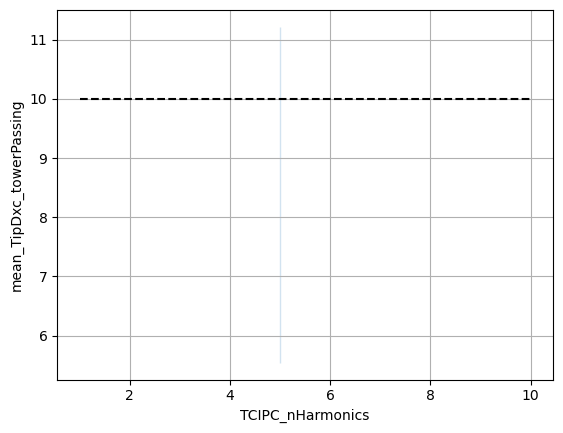

In [5]:
sns.lineplot(df, x="TCIPC_nHarmonics", y="mean_TipDxc_towerPassing")
plt.hlines([10], 1, 10, "k", "--")
plt.grid()

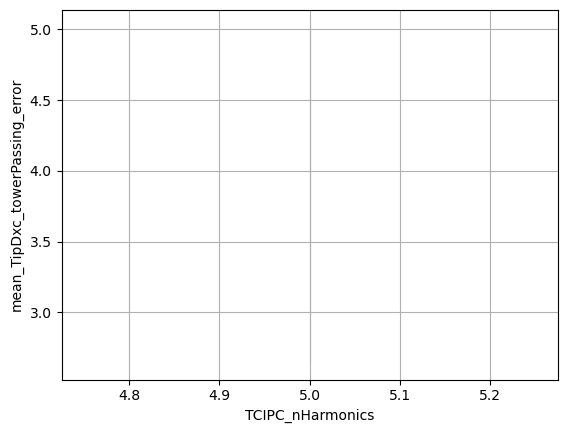

In [6]:
sns.lineplot(df, x="TCIPC_nHarmonics", y="mean_TipDxc_towerPassing_error")
# plt.hlines([10], 1, 10, "k", "--")
# plt.ylim([0, 0.15])
plt.grid()

In [7]:
import pickle
import glob
import os
import re

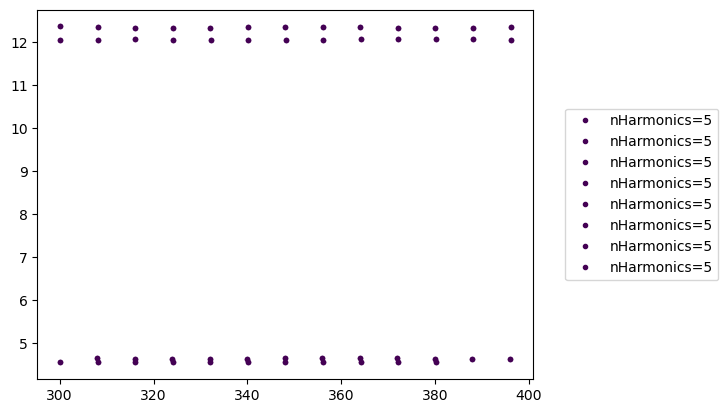

In [8]:
timeseries_glob = os.path.join(
    os.path.dirname(log_fmt), "openfast_runs/rank_*/iteration_*/timeseries/weis_job*.p"
)
# timeseries_glob = "/home/jesse/Projects/Tower-clearance-co-design/data/design_of_experiments/ps_vs_ipc_harmonics/

# Collect all data first to sort by nHarmonics
plot_data = []
for filepath in sorted(glob.glob(timeseries_glob)):
    # Extract rank and iteration from filepath
    match = re.search(r"/rank_(\d+)/iteration_(\d+)/", filepath)
    rank = int(match.group(1))
    iter_num = int(match.group(2))

    # Get TCIPC_nHarmonics from dataframe
    nharmonics_value = int(
        df[(df["rank"] == rank) & (df["iter"] == iter_num)]["TCIPC_nHarmonics"].values[
            0
        ]
    )

    with open(filepath, "rb") as f:
        ts = pickle.load(f)
        mask = (ts.Azimuth > 179.5) & (ts.Azimuth < 180.5)
        plot_data.append((nharmonics_value, ts.Time[mask], ts.TipDxc1[mask]))

# Sort by nHarmonics and plot with continuous colormap
sorted_data = sorted(plot_data, key=lambda x: x[0])
nharmonics_values = [x[0] for x in sorted_data]
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(nharmonics_values), vmax=max(nharmonics_values))

for nharmonics, time, tipdxc in sorted_data:
    color = cmap(norm(nharmonics))
    # Use 'x' markers for nHarmonics 3 and 7, dots for others
    marker = "x" if nharmonics in [3, 7] else "."
    plt.plot(time, tipdxc, marker, color=color, label=f"nHarmonics={nharmonics}")

# # Add colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# plt.colorbar(sm, label="Number of Harmonics")

plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
# plt.xlim([600, 650])

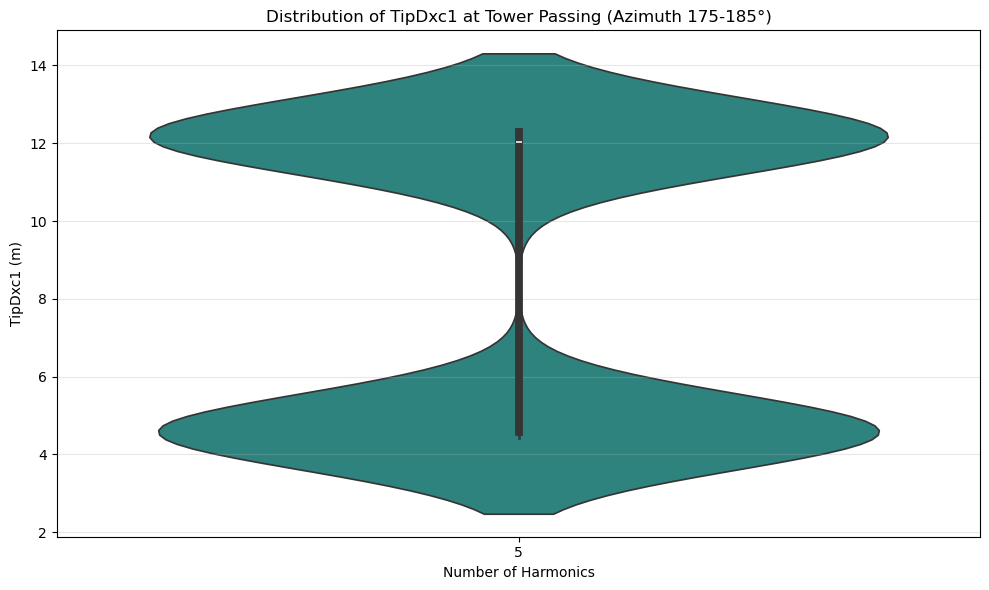

In [9]:
# Distribution plot of TipDxc1 for each nHarmonics value using violin plots
fig, ax = plt.subplots(figsize=(10, 6))

# Collect distribution data for each nHarmonics
distribution_data = {}
for filepath in sorted(glob.glob(timeseries_glob)):
    # Extract rank and iteration from filepath
    match = re.search(r"/rank_(\d+)/iteration_(\d+)/", filepath)
    rank = int(match.group(1))
    iter_num = int(match.group(2))

    # Get TCIPC_nHarmonics from dataframe
    nharmonics_value = int(
        df[(df["rank"] == rank) & (df["iter"] == iter_num)]["TCIPC_nHarmonics"].values[
            0
        ]
    )

    with open(filepath, "rb") as f:
        ts = pickle.load(f)
        mask = (ts.Azimuth > 175) & (ts.Azimuth < 185)

        if nharmonics_value not in distribution_data:
            distribution_data[nharmonics_value] = []
        distribution_data[nharmonics_value].extend(ts.TipDxc1[mask].tolist())

# Prepare data for violin plot
plot_data = []
for nharmonics in sorted(distribution_data.keys()):
    for value in distribution_data[nharmonics]:
        plot_data.append({"nHarmonics": nharmonics, "TipDxc1": value})

df_plot = pd.DataFrame(plot_data)

# Create violin plot
sns.violinplot(data=df_plot, x="nHarmonics", y="TipDxc1", ax=ax, palette="viridis")

ax.set_xlabel("Number of Harmonics")
ax.set_ylabel("TipDxc1 (m)")
ax.set_title("Distribution of TipDxc1 at Tower Passing (Azimuth 175-185°)")
ax.grid(alpha=0.3, axis="y")
plt.tight_layout()

In [10]:
# TEMPORARY

In [11]:
df

,rank,iter,TCIPC_MaxTipDeflection,ps_percent,TCIPC_nHarmonics,TCIPC_ZeroYawDeflection,aep,max_TipDxc_towerPassing,mean_TipDxc_towerPassing,mean_TipDxc_towerPassing_error,tower_clearance,avg_pitch_travel,DEL_RootMyb,max_TwrBsMyt
0,0,0,0.0,0.5,5.0,0.0,130.030433,4.674636,4.535514,5.464486,25.325364,0.003652,11327.304964,109731.976562
1,1,0,20.0,0.5,5.0,0.0,126.849054,12.061696,12.050221,2.050221,17.938304,2.506524,40382.495219,72308.132812
2,2,0,0.0,0.5,5.0,0.0,130.030433,4.674636,4.535514,5.464486,25.325364,0.003652,11327.304964,109731.976562
3,3,0,20.0,0.5,5.0,0.0,126.849054,12.061696,12.050221,2.050221,17.938304,2.506524,40382.495219,72308.132812
4,4,0,0.0,1.0,5.0,0.0,131.399901,4.770731,4.624213,5.375787,25.229269,0.008777,11345.341653,112354.085938
5,5,0,20.0,1.0,5.0,0.0,131.400338,12.366404,12.335707,2.335707,17.633596,2.507011,40295.226080,79917.398438
6,6,0,0.0,1.0,5.0,0.0,131.399901,4.770731,4.624213,5.375787,25.229269,0.008777,11345.341653,112354.085938
7,7,0,20.0,1.0,5.0,0.0,131.400338,12.366404,12.335707,2.335707,17.633596,2.507011,40295.226080,79917.398438
